In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

import idx2numpy
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Check if cuda is avilable in torch
if torch.cuda.is_available():
    print("Detect GPU: {}".format(torch.cuda.get_device_name()))
    device = torch.device('cuda')
else:
    print('No GPU Detected')
    device = torch.device('cpu')

Detect GPU: GeForce GTX 1080


In [3]:
is_transfer_learning = False

In [4]:
# Load images and label
test_images = idx2numpy.convert_from_file('data/raw/t10k-images-idx3-ubyte')
test_labels = idx2numpy.convert_from_file('data/raw/t10k-labels-idx1-ubyte')

In [5]:
# Create cnn to load
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(3200, 256)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        
        return output

In [6]:
if not is_transfer_learning:
    model = SimpleCNN() # Load cnn structure
    model.to(device) # Convert model to gpu mode
    model.load_state_dict(torch.load('simple_cnn.pth')) # Load weights to gpu
    model.eval() # Set to eval mode for inference
else:
    model = torchvision.models.resnet50(pretrained=True)
    # Freeze model weights
    for param in model.parameters():
        param.requires_grad = False
    
    model.conv1 = nn.Conv2d(1, 64, 3, 1)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 10),
        nn.LogSoftmax(dim=1)
    )
    model.to(device)
    model.load_state_dict(torch.load('resnet_cnn.pth'))

In [7]:
labels = [
    'T-shirt-Top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

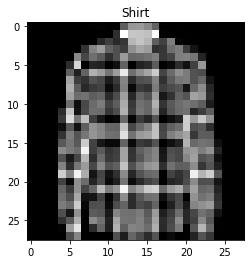

In [8]:
# Single inference
with torch.no_grad():
    img = test_images[7] # Select image
    img_copy = img.copy() # Make a copy of the image
    img = np.expand_dims(img, axis=0) # Add 1 dim color channel to front
    img = img / 255. # normalize image
    img = torch.tensor(img, dtype=torch.float) # convert numpy arry to torch tensor (torch expect this format)
    img = torch.unsqueeze(img, 1) # Add 1 dimension for batch so format looks like this (1, 1, 28, 28)
    img = img.to(device) # Remember torch loads gpu to said variable(tensor) when running training or inference
    
    output = model(img) # Forward pass
    
    pred = output.detach().cpu().numpy() # Once inference is done convert gpu tensor to cpu numpy array
    true_pred = np.argmax(pred) # Get highest position
    
    # Display
    plt.title(labels[true_pred])
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_GRAY2RGB))

# Batch inference

In [10]:
batch_inf_imgs = []
for test_image in test_images:
    test_image = test_image / 255.
    test_image = np.expand_dims(test_image, axis=0)
    batch_inf_imgs.append(test_image)
    
batch_inf_imgs = torch.tensor(batch_inf_imgs, dtype=torch.float).to(device)

In [14]:
with torch.no_grad():
    preds = model(batch_inf_imgs)
    _, preds = torch.max(preds.data, 1)

    preds = preds.detach().cpu().numpy()

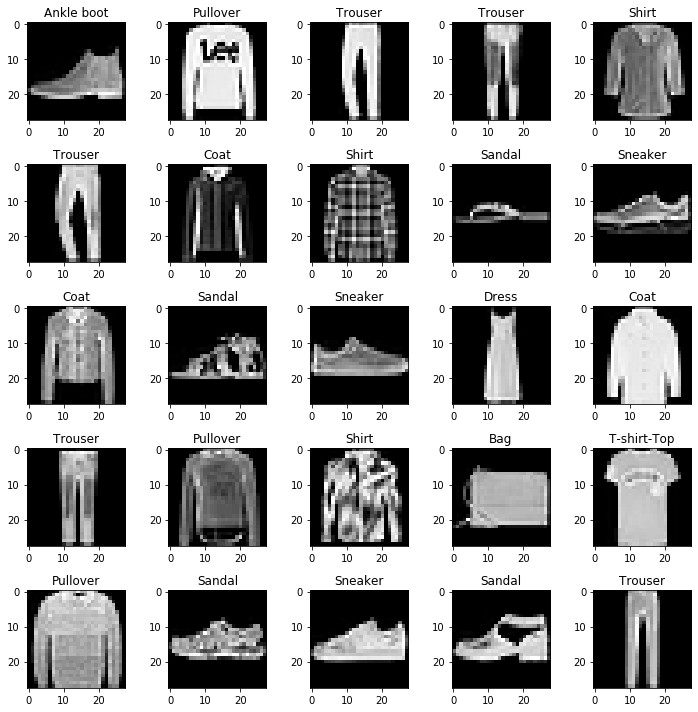

In [20]:
row, column = 5, 5
count = 0
plt.figure(figsize=(10, 10))

for i in range(row * column):
    img = test_images[i]
    pred_label = preds[i]
    
    count += 1
    plt.subplot(row, column, count)
    plt.title(labels[pred_label])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
    
plt.tight_layout()